## KeepUp Challenge  
  
This challenge focus on analyzing product information from amazon products. I start by loading the packages I will be using:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter
import heapq
from copy import deepcopy

# Ratings  
  
I start off by looking at the ratings. I focus on the average rating for each product, which I read into a list below:

In [2]:
avg_reviews = []
with open("amazon-meta.txt") as amazon_file:
    for line in amazon_file:
        line = ' '.join(line.split())
        line_words = line.strip().split(' ')
        if line_words[0] == "reviews:":
            avg_reviews.append(float(line_words[-1]))

len(avg_reviews)

542684

Plotting the number of products with each review value gives a sense of what the distribution of ratings looks like:

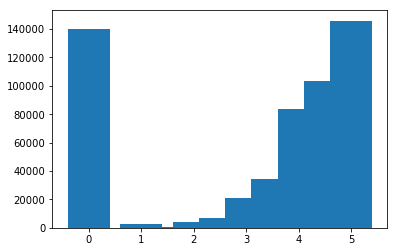

In [3]:
avg_review_counts = pd.Series(avg_reviews).value_counts()
plt.bar(avg_review_counts.index, avg_review_counts.values)
plt.show()

There is a large amount of products with a rating of zero. From examining the data file, I noticed that products that have no reviews by default have a rating of zero, which likely accounts for many of these ratings. Besides the zero ratings, the distribution is heavily concentrated near to top rating of five.

# Categories  
  
I next look at the categorization used for the products, focusing only on books. Using the data file, I read each product into a dictionary with keys that are the amazon product ID number and whose contents is a list of the most detailed (lowest level in the hierarchy) categories to which that product belongs:

In [4]:
category_dict = {}
category_count = Counter()
with open("amazon-meta.txt") as amazon_file:
    line_cat = 0
    for line in amazon_file:
        line = ' '.join(line.split())
        line_words = line.strip().split(' ')
        if line_words[0] == "ASIN:":
            line_asin = line_words[-1]
        if (line_words[0] == "group:") & (line_words[-1] == "Book"):
            line_cat = 1
            category_dict[line_asin] = []
        elif (line_words[0] == "group:") & (line_words[-1] != "Book"):
            line_cat = 0
        if (line_cat == 1) & (line[0:6] == "|Books"):
            category_dict[line_asin].append(line.split('|')[-1])
            category_count[line.split('|')[-1]] += 1

len(category_dict)

393561

In [5]:
category_dict

{'0827229534': ['Preaching[12368]', 'Sermons[12370]'],
 '0738700797': ['Wicca[12484]', 'Witchcraft[12486]'],
 '0486287785': ['General[5144]'],
 '0842328327': ['New Testament[12159]',
  'Discipleship[12335]',
  'Life Application[572080]',
  'New Testament[572082]',
  'General[572094]'],
 '1577943082': ['Prayerbooks[12470]', 'Business[297488]'],
 '0486220125': ['Photo Essays[2082]',
  'General[4870]',
  'General[4993]',
  'Urban[11296]'],
 '0231118597': ['General[10716]',
  'Criminology[11005]',
  'General[11083]',
  'U.S.[11117]'],
 '1859677800': ['Bread[4197]'],
 '0375709363': ['General[10213]',
  'History & Theory[11086]',
  'Cultural[11235]'],
 '0871318237': ['General[4701]',
  'General[14046]',
  'General[227584]',
  'jp-unknown2[1061350]'],
 '1590770218': ['Herbs, Spices & Condiments[4211]',
  'General[4233]',
  'Diabetic & Sugar-Free[4318]',
  'Low Fat[4323]',
  'General[4628]',
  'Low Carbohydrate[4639]',
  'Low Sugar[4642]',
  'Low-Fat Diet[282849]',
  'Low Carb[10924671]'],
 '0

There are multiple ways that a category could be considered bloated. One is redundancy, e.g. there are categories like Wicca and Witchcraft that tend to contain the same products. This type of bloat could be addressed by looking for categories with large overlaps in terms of the products they contain. Another type of bloat can come from categories that contain very few products. For example, in the extreme, some categories may only contain a single product. Having counted the number of products in each bottom-level category, I can say this is the case for some categories in this dataset:

In [6]:
heapq.nsmallest(10, category_count.items(), key=itemgetter(1))

[('Image Composer[4154]', 1),
 ('Blatty, William P.[5778]', 1),
 ('Block, Lawrence[585764]', 1),
 ('Ravel, Maurice[1572]', 1),
 ('Kadohata, Cynthia[15433]', 1),
 ('Norman, Hilary[565680]', 1),
 ('Gass, William[70277]', 1),
 ('Marsh, Ngaio[585820]', 1),
 ('Greek[3151711]', 1),
 ('Claybourne, Casey[12921]', 1)]

A subsequent question asks about the ability to eliminate categories without losing too many category entries. The ability to eliminate many categories while losing few entries is in itself one way of assessing category bloat. As a first pass at answering this question, I restrict myself to only eliminating categories at the lowest level of the category hierarchy. I also focus on removing the smallest categories, rather than the categories with the highest overlap. My reason for doing this is that I think there is a lot of low hanging fruit becasue there are so many categories with very few entries, and so eliminating the smallest categories is a fast and simple way to eliminate many categories. This method could be improved very easily and simply by first applying this simple approach to capture a lot of the "low hanging fruit" and then once the remaining categories start to get bigger adding the consideration of redundant categories by calculating overlap between categories and merging ones with high overlap. For now, I focus on the simple method. There are over 11,000 categories, and I start off by considering the smallest 8,000 for deletion:

In [7]:
len(category_count)

11316

In [8]:
least_count_categories = heapq.nsmallest(8000, category_count.items(), key=itemgetter(1))
8000/len(category_count)

0.7069635913750442

I prepare a list of these smallest categories:

In [9]:
smallest_cat_list = []
for i in range(0, len(least_count_categories)):
    smallest_cat_list.append(least_count_categories[i][0])
    
smallest_cat_list = set(smallest_cat_list)
smallest_cat_list

{'Kushner, Tony[70398]',
 'White, Stephen[69689]',
 'General[284617]',
 'Acoustics[226716]',
 'Camus, Albert[917094]',
 'New Hampshire & Vermont[16445]',
 'Ellis, Julie[565668]',
 'Willard, Dallas[173184]',
 'General[3049211]',
 'Sociology[3148]',
 'Donleavy, J.P.[70217]',
 'Fielding, Joy[565686]',
 'Muslim[1804]',
 'Paperback[285715]',
 'Eloise[184940]',
 'Computers & Internet[4461]',
 'Nanostructures[227410]',
 'Military[2490]',
 'Rule, Ann[69624]',
 'Theory[491488]',
 'Dunbar, Paul Laurence[70233]',
 'Pence, Joanne[69583]',
 'Churchill, Caryl[70174]',
 'Wiesel, Elie[297996]',
 'Structures[298548]',
 'National Geographic Park Profiles[17111]',
 'Gentileschi, Artemisia[1236]',
 'Vedic[297528]',
 'Oil Painting[171126]',
 'Allen, Charlotte Vale[466324]',
 'Bazille, Frederic[1125]',
 'Paperback[285759]',
 'Fox, Emmet[173062]',
 'North Cascades[67550]',
 'Horror[2500]',
 'Odom, Mel[15743]',
 'Yiddish[3151771]',
 'Large Print[287440]',
 'Reference[300955]',
 'Pike, Christopher[69591]',
 'F

I next prepare a new dictionary with products that are members of these categories deleted and look at how many products remain:

In [10]:
category_dict_temp = deepcopy(category_dict)
for key_j in list(category_dict_temp.keys()):
    if not(smallest_cat_list.isdisjoint(category_dict_temp[key_j])):
        del category_dict_temp[key_j]

In [11]:
len(category_dict_temp)/len(category_dict)

0.7749878671921252

With these products, deleting 70% of the categories by this method would effect only about 25% of the products.

# Algorithm thinking  
  
One way to build a categorization from scratch using some data that gets at similarity would be to use hierarchical clustering to join similar products into categories.

# Product thinking  
  
For all of these it could be good or bad to show customers certain information depending on exactly what is shown. Showing customers categories will help them navigate to products they are looking for, but showing too much could be confusing, so it could be advisable to hide certain parts of the categorization. Showing similar or co-purchased items could be good if it enduces the customer to also purchase those items, but some similar items may acutally be distracting or annoying to customers, for example showing something based on "similarity" that is redundant with what the customer may have already purchased. Showing ratings and reviews may help customers make decisions, but could also be distracting or misleading or even exploitative is the ratings/reviews are subject to manipulation. There are many ways that a company could establish what things to show, for example, running A/B tests with some content shown or not, logging clicks on certain information, or asking customers for feedback about what they found helpful.